# <span style="font-width:bold; font-size: 3rem; color:#1EB182;"> **Air Quality** </span><span style="font-width:bold; font-size: 3rem; color:#333;">- Part 04: Batch Inference</span>

## 🗒️ This notebook is divided into the following sections:

1. Download model and batch inference data
2. Make predictions, generate PNG for forecast
3. Store predictions in a monitoring feature group adn generate PNG for hindcast

## <span style='color:#ff5f27'> 📝 Imports

In [1]:
import datetime
import pandas as pd
from xgboost import XGBRegressor
import hopsworks
import json
from functions import util
import os
import numpy as np

2024-11-20 18:14:45,076 WARNING: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.

2024-11-20 18:14:45,077 WARNING: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.



In [2]:
today = datetime.datetime.now() - datetime.timedelta(0)
tomorrow = today + datetime.timedelta(days = 1)
today

datetime.datetime(2024, 11, 20, 18, 14, 46, 134451)

## <span style="color:#ff5f27;"> 📡 Connect to Hopsworks Feature Store </span>

In [3]:
with open('../../data/hopsworks-api-key.txt', 'r') as file:
    os.environ["HOPSWORKS_API_KEY"] = file.read().rstrip()
project = hopsworks.login()
fs = project.get_feature_store() 

secrets = util.secrets_api(project.name)
location_str = secrets.get_secret("SENSOR_LOCATION_JSON").value
location = json.loads(location_str)
country=location['country']
city=location['city']
street=location['street']

Connected. Call `.close()` to terminate connection gracefully.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1164445
2024-11-20 18:14:47,678 WARNING: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses

Connected. Call `.close()` to terminate connection gracefully.
Connected. Call `.close()` to terminate connection gracefully.


## <span style="color:#ff5f27;"> ⚙️ Feature View Retrieval</span>


In [4]:
feature_view = fs.get_feature_view(
    name='air_quality_fv',
    version=4,
)

## <span style="color:#ff5f27;">🪝 Download the model from Model Registry</span>

In [5]:
mr = project.get_model_registry()

retrieved_model = mr.get_model(
    name="air_quality_xgboost_model_with_lagged_data",
    version=1,
)

# Download the saved model artifacts to a local directory
saved_model_dir = retrieved_model.download()

Connected. Call `.close()` to terminate connection gracefully.


In [6]:
# Loading the XGBoost regressor model and label encoder from the saved model directory
# retrieved_xgboost_model = joblib.load(saved_model_dir + "/xgboost_regressor.pkl")
retrieved_xgboost_model = XGBRegressor()

retrieved_xgboost_model.load_model(saved_model_dir + "/model.json")

# Displaying the retrieved XGBoost regressor model
retrieved_xgboost_model

XGBRegressor(base_score='2.327862E1', booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None,
             feature_types=['float', 'float', 'float', 'float', 'float',
                            'float', 'float'],
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

## <span style="color:#ff5f27;">✨ Get Weather Forecast Features with Feature Group   </span>



In [7]:
weather_fg = fs.get_feature_group(
    name='weather',
    version=1,
)
batch_data = weather_fg.filter(weather_fg.date >= today).read()
batch_data

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.77s) 


,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city
0,2024-11-23 00:00:00+00:00,-3.20,0.0,2.741678,113.198624,helsinki
1,2024-11-25 00:00:00+00:00,6.80,0.3,32.379993,208.559525,helsinki
2,2024-11-24 00:00:00+00:00,-1.45,0.0,7.594208,238.570480,helsinki
3,2024-11-22 00:00:00+00:00,-1.45,0.2,14.336861,241.504456,helsinki
4,2024-11-21 00:00:00+00:00,2.95,0.1,30.652895,192.893738,helsinki
5,2024-11-26 00:00:00+00:00,7.95,0.2,22.392464,216.501526,helsinki
6,2024-11-27 00:00:00+00:00,6.95,0.2,18.000000,196.260284,helsinki
7,2024-11-28 00:00:00+00:00,5.95,0.4,4.349896,245.556061,helsinki
8,2024-11-29 00:00:00+00:00,-0.35,0.0,5.623380,320.194489,helsinki


### <span style="color:#ff5f27;">🤖 Making the predictions</span>

In [8]:
# Get air_quality data
air_quality_fg = fs.get_feature_group(
   name='air_quality',
   version=2,
)
historical_data = air_quality_fg.select_all().read()
# Remove timezone info and sort
historical_data['date'] = pd.to_datetime(historical_data['date']).dt.tz_localize(None)
batch_data['date'] = pd.to_datetime(batch_data['date']).dt.tz_localize(None)
batch_data = batch_data.sort_values('date').reset_index(drop=True)

# Set initial lagged values
last_3_pm25 = list(historical_data.tail(3)['pm25'])[::-1]
batch_data.loc[0, ['pm25_lag_1','pm25_lag_2','pm25_lag_3']] = last_3_pm25

for i in range(len(batch_data)):
   features = [
       batch_data.at[i, 'pm25_lag_1'],
       batch_data.at[i, 'pm25_lag_2'], 
       batch_data.at[i, 'pm25_lag_3'],
       batch_data.at[i, 'temperature_2m_mean'],
       batch_data.at[i, 'precipitation_sum'],
       batch_data.at[i, 'wind_speed_10m_max'],
       batch_data.at[i, 'wind_direction_10m_dominant']
   ]
   
   pred = retrieved_xgboost_model.predict([features])[0]
   batch_data.at[i, 'predicted_pm25'] = pred
   
   if i < len(batch_data) - 1:
       batch_data.loc[i+1, ['pm25_lag_1','pm25_lag_2','pm25_lag_3']] = [
           pred, 
           batch_data.at[i, 'pm25_lag_1'],
           batch_data.at[i, 'pm25_lag_2']
       ]

# Convert float columns to float32 once at the end
float_columns = batch_data.select_dtypes(include=['float64']).columns
batch_data[float_columns] = batch_data[float_columns].astype('float32')

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.33s) 


In [9]:
batch_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 10 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   date                         9 non-null      datetime64[us]
 1   temperature_2m_mean          9 non-null      float32       
 2   precipitation_sum            9 non-null      float32       
 3   wind_speed_10m_max           9 non-null      float32       
 4   wind_direction_10m_dominant  9 non-null      float32       
 5   city                         9 non-null      object        
 6   pm25_lag_1                   9 non-null      float32       
 7   pm25_lag_2                   9 non-null      float32       
 8   pm25_lag_3                   9 non-null      float32       
 9   predicted_pm25               9 non-null      float32       
dtypes: datetime64[us](1), float32(8), object(1)
memory usage: 560.0+ bytes


### <span style="color:#ff5f27;">🤖 Saving the predictions (for monitoring) to a Feature Group</span>

In [10]:
batch_data['street'] = street
batch_data['city'] = city
batch_data['country'] = country
# Fill in the number of days before the date on which you made the forecast (base_date)
batch_data['days_before_forecast_day'] = range(1, len(batch_data)+1)
batch_data = batch_data.sort_values(by=['date'])
batch_data

,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city,pm25_lag_1,pm25_lag_2,pm25_lag_3,predicted_pm25,street,country,days_before_forecast_day
0,2024-11-21,2.95,0.1,30.652895,192.893738,helsinki,39.000000,10.000000,8.000000,50.308029,kallio-2,finland,1
1,2024-11-22,-1.45,0.2,14.336861,241.504456,helsinki,50.308029,39.000000,10.000000,42.236870,kallio-2,finland,2
2,2024-11-23,-3.20,0.0,2.741678,113.198624,helsinki,42.236870,50.308029,39.000000,56.989681,kallio-2,finland,3
3,2024-11-24,-1.45,0.0,7.594208,238.570480,helsinki,56.989681,42.236870,50.308029,55.815067,kallio-2,finland,4
4,2024-11-25,6.80,0.3,32.379993,208.559525,helsinki,55.815067,56.989681,42.236870,42.849792,kallio-2,finland,5
5,2024-11-26,7.95,0.2,22.392464,216.501526,helsinki,42.849792,55.815067,56.989681,31.704742,kallio-2,finland,6
6,2024-11-27,6.95,0.2,18.000000,196.260284,helsinki,31.704742,42.849792,55.815067,38.341618,kallio-2,finland,7
7,2024-11-28,5.95,0.4,4.349896,245.556061,helsinki,38.341618,31.704742,42.849792,33.584137,kallio-2,finland,8
8,2024-11-29,-0.35,0.0,5.623380,320.194489,helsinki,33.584137,38.341618,31.704742,39.050220,kallio-2,finland,9


In [11]:
batch_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 13 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   date                         9 non-null      datetime64[us]
 1   temperature_2m_mean          9 non-null      float32       
 2   precipitation_sum            9 non-null      float32       
 3   wind_speed_10m_max           9 non-null      float32       
 4   wind_direction_10m_dominant  9 non-null      float32       
 5   city                         9 non-null      object        
 6   pm25_lag_1                   9 non-null      float32       
 7   pm25_lag_2                   9 non-null      float32       
 8   pm25_lag_3                   9 non-null      float32       
 9   predicted_pm25               9 non-null      float32       
 10  street                       9 non-null      object        
 11  country                      9 non-null      obje

### Create Forecast Graph
Draw a graph of the predictions with dates as a PNG and save it to the github repo
Show it on github pages

DataFrame columns:
['date', 'temperature_2m_mean', 'precipitation_sum', 'wind_speed_10m_max', 'wind_direction_10m_dominant', 'city', 'pm25_lag_1', 'pm25_lag_2', 'pm25_lag_3', 'predicted_pm25', 'street', 'country', 'days_before_forecast_day']

First rows of DataFrame:
        date  temperature_2m_mean  precipitation_sum  wind_speed_10m_max  \
0 2024-11-21                 2.95                0.1           30.652895   
1 2024-11-22                -1.45                0.2           14.336861   
2 2024-11-23                -3.20                0.0            2.741678   
3 2024-11-24                -1.45                0.0            7.594208   
4 2024-11-25                 6.80                0.3           32.379993   

   wind_direction_10m_dominant       city  pm25_lag_1  pm25_lag_2  pm25_lag_3  \
0                   192.893738  helsinki    39.000000   10.000000    8.000000   
1                   241.504456  helsinki    50.308029   39.000000   10.000000   
2                   113.198624  

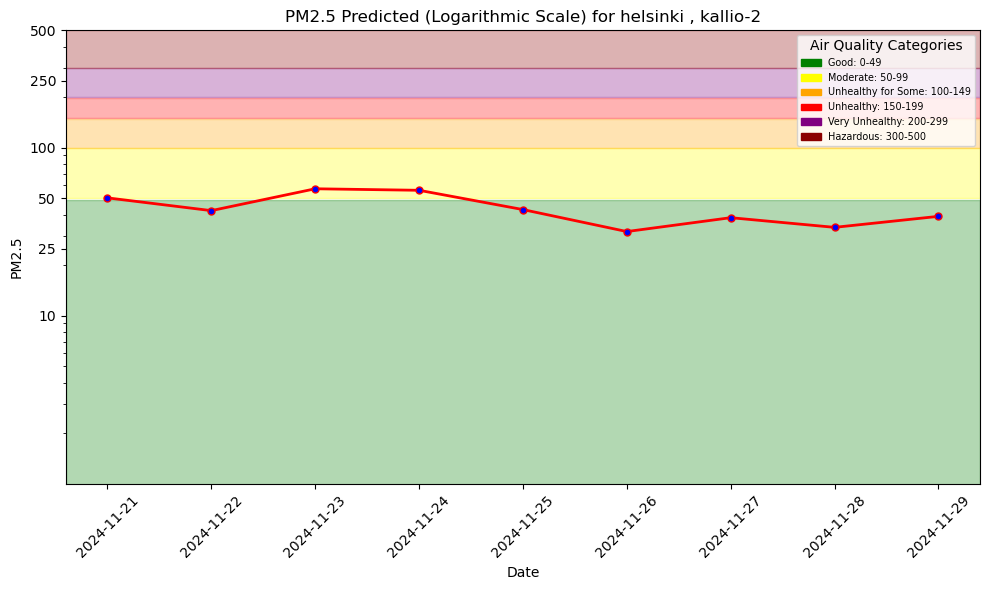

In [12]:
file_path = "../../docs/air-quality/assets/img/pm25_forecast.png"

# Create directories if they don't exist
directory = os.path.dirname(file_path)
if not os.path.exists(directory):
    os.makedirs(directory)

# Check DataFrame columns
print("DataFrame columns:")
print(batch_data.columns.tolist())

# Display first few rows
print("\nFirst rows of DataFrame:")
print(batch_data.head())

plt = util.plot_air_quality_forecast(city, street, batch_data, file_path)
plt.show()

In [13]:
# Get or create feature group
monitor_fg = fs.get_or_create_feature_group(
    name='aq_predictions',
    description='Air Quality prediction monitoring',
    version=2,
    primary_key=['city','street','date','days_before_forecast_day'],
    event_time="date"
)

In [ ]:
monitor_fg.insert(batch_data, write_options={"wait_for_job": True})

2024-11-20 18:15:00,970 WARNING: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.



Uploading Dataframe: 0.00% |          | Rows 0/9 | Elapsed Time: 00:00 | Remaining Time: ?

Launching job: aq_predictions_2_offline_fg_materialization
Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai/p/1164445/jobs/named/aq_predictions_2_offline_fg_materialization/executions


In [ ]:
# We will create a hindcast chart for  only the forecasts made 1 day beforehand
monitoring_df = monitor_fg.filter(monitor_fg.days_before_forecast_day == 1).read()
monitoring_df

In [ ]:
air_quality_fg = fs.get_feature_group(
    name='air_quality',
    version=2,
)
air_quality_df = air_quality_fg.read().sort_values('date').reset_index(drop=True)
air_quality_df

In [ ]:
outcome_df = air_quality_df[['date', 'pm25']]
preds_df =  monitoring_df[['date', 'predicted_pm25']]

hindcast_df = pd.merge(preds_df, outcome_df, on="date")
hindcast_df = hindcast_df.sort_values(by=['date'])

# If there are no outcomes for predictions yet, generate some predictions/outcomes from existing data
if len(hindcast_df) == 0:
    hindcast_df = util.backfill_predictions_for_monitoring(weather_fg, air_quality_df, monitor_fg, retrieved_xgboost_model)
hindcast_df

### Plot the Hindcast comparing predicted with forecasted values (1-day prior forecast)

__This graph will be empty to begin with - this is normal.__

After a few days of predictions and observations, you will get data points in this graph.

In [ ]:
file_path = "../../docs/air-quality/assets/img/pm25_hindcast_1day.png"
plt = util.plot_air_quality_forecast(city, street, hindcast_df, file_path, hindcast=True)
plt.show()

---